In [122]:
%matplotlib inline

import sys
import os
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tsd
import geojson
import folium
import rasterio
from sklearn.linear_model import LinearRegression

sys.path.append("../forestry_yield_estimation")
import vistools, utils

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

data_path = Path("../data")
points_path = data_path / "points/export.csv"
image_path = data_path / "images" / "south"
output_path = Path("../report/img/eda")

In [2]:
from preprocessing import read_raw_points_data
df = read_raw_points_data(data_path)

In [3]:
import pint
ureg = pint.UnitRegistry()

In [42]:
# Density of eucalyptus dunnii
density = 500 * ureg("kg / m**3")
density = density.to("Mg/meter**3")
density

0.5 <Unit('megagram / meter ** 3')>

Saturation happens around 50 Mg/ha on C-band.

In [43]:
mass_saturation = 50 * ureg.Mg / ureg.hectare
volume_saturation = (mass_saturation / density).to("meter**3/hectare")
volume_saturation

100.0 <Unit('meter ** 3 / hectare')>

In [44]:
spacing = (3.5*ureg.meter, 2.14*ureg.meter)
trees_per_hectare = (1 / (spacing[0]*spacing[1])).to("1/hectare")
trees_per_hectare

1335.1134846461948 <Unit('1 / hectare')>

In [45]:
area_per_tree = (spacing[0]*spacing[1]).to("hectare")
area_per_tree.to("meter**2")

7.490000000000001 <Unit('meter ** 2')>

In [46]:
volume_saturation_per_tree = volume_saturation / trees_per_hectare
volume_saturation_per_tree

0.07490000000000001 <Unit('meter ** 3')>

In [47]:
print(f"""\
The density is {density.to("gram/centimeter**3"):~P}, which is equal to {density:.3~P}.

Saturation happens at {mass_saturation:~P}, which dividing by the density gives a
saturation point at {volume_saturation:.3~P}.

The spacing of the trees is {spacing[0]:~P} x {spacing[1]:~P}, which means there are about
{trees_per_hectare.magnitude:.0f} trees per hectare.

Therefore, the saturation volume per tree is {volume_saturation_per_tree:.4~P}.
""")

The density is 0.5000000000000001 g/cm³, which is equal to 0.5 Mg/m³.

Saturation happens at 50.0 Mg/ha, which dividing by the density gives a
saturation point at 1×10² m³/ha.

The spacing of the trees is 3.5 m x 2.14 m, which means there are about
1335 trees per hectare.

Therefore, the saturation volume per tree is 0.0749 m³.



In [48]:
print(f"""\
Saturation happens at {mass_saturation:~P}. This quantity is called the AGB (Above Ground Biomass)
and we want to estimate it from the measurements we have.

The density of E. Dunnii is {density.to("gram/centimeter**3"):~P}, which is equal to {density:.3~P}.

The spacing of the trees is {spacing[0]:~P} x {spacing[1]:~P}, which means there are about
{trees_per_hectare.magnitude:.0f} trees per hectare.

The volume can be estimated by multiplying the basal area by the height and multiplying by
a correction factor of approximately 1/2.

Then, the AGB is equal to the volume times the density of the tree, times the number of trees per hectare,
converted to Mg/ha.
""")

Saturation happens at 50.0 Mg/ha. This quantity is called the AGB (Above Ground Biomass)
and we want to estimate it from the measurements we have.

The density of E. Dunnii is 0.5000000000000001 g/cm³, which is equal to 0.5 Mg/m³.

The spacing of the trees is 3.5 m x 2.14 m, which means there are about
1335 trees per hectare.

The volume can be estimated by multiplying the basal area by the height and multiplying by
a correction factor of approximately 1/2.

Then, the AGB is equal to the volume times the density of the tree, times the number of trees per hectare,
converted to Mg/ha.



In [28]:
ureg("m**2")

1 <Unit('meter ** 2')>

# Figuring out the units
Here we show that it is very likely that the basal area is expressed in m^2 / ha and the volume is expressed in Mg/ha which is a standard unit for AGB in the literature.

In [55]:
df["est_basal_area"] = (df["diameter"]**2/4*np.pi) * ureg("cm**2").to("m**2").magnitude # m^2
df["est_basal_area_per_ha"] = df["est_basal_area"] * trees_per_hectare.magnitude # m^2 / ha
df["est_volume"] = df["est_basal_area"] * df.height * 0.5 # m^3

agb = (df["est_volume"].values * ureg("m**3") * density * trees_per_hectare).to("Mg/ha")
df["agb"] = agb.magnitude # Mg/ha

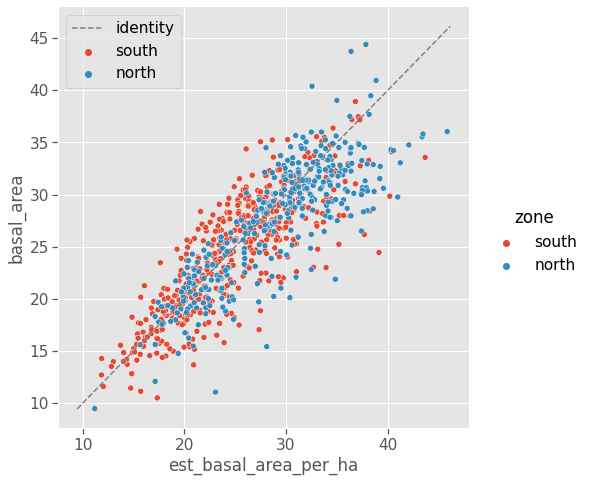

In [56]:
g = sns.relplot(data=df, x="est_basal_area_per_ha", y="basal_area", hue="zone", height=7)
vistools.add_identity_to_plot(g.ax)
g.tight_layout()
plt.savefig(output_path/"basal_area.png")

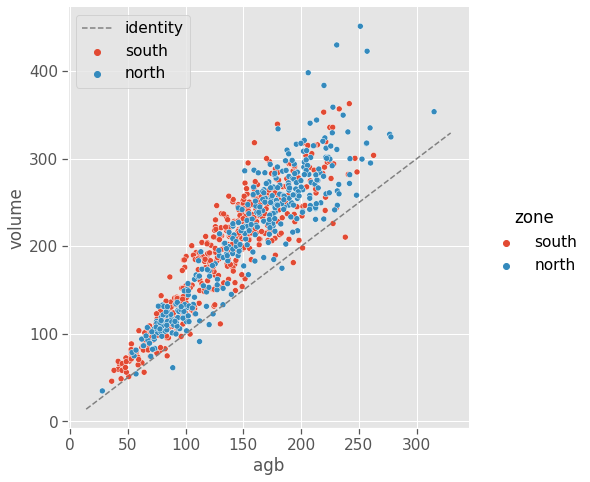

In [57]:
g = sns.relplot(data=df, x="agb", y="volume", hue="zone", height=7)
vistools.add_identity_to_plot(g.ax)
g.tight_layout()
plt.savefig(output_path/"agb.png")

In [105]:
print(f"""\
{(df["volume"] < 50).mean():.2%} of measurements are under the theoretical saturation point in official measurements.
{(df["agb"] < 50).mean():.2%} of measurements are in our estimated measurements.
""")

0.36% of measurements are under the theoretical saturation point in official measurements.
1.70% of measurements are in our estimated measurements.



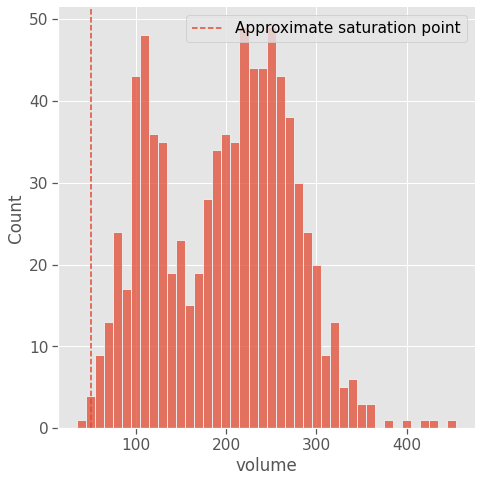

In [118]:
sns.displot(data=df, x="volume", height=7, binwidth=10)
plt.axvline(50, ls="--", label="Approximate saturation point")
plt.legend()
plt.savefig(output_path/"saturation.png")

In [60]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False).fit(df.agb.to_frame(), df.volume)
print("Slope:", lr.coef_[0])

Slope: 1.3892950361111545


# Alternative volume calculation (Schneider et al.)

In [70]:
v = np.exp(-9.06566 + 0.93016 * np.log(df["diameter"]**2 * df["height"]))
agb = (v.values * ureg("m**3") * density * trees_per_hectare).to("Mg/ha")

/home/nathra/.local/lib/python3.8/site-packages/numpy/ma/core.py:2825: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


<AxesSubplot:>

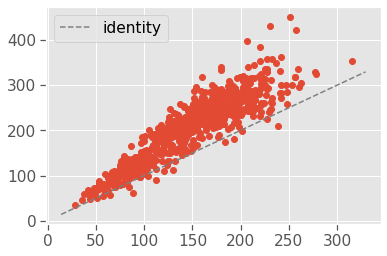

In [69]:
fig, ax = plt.subplots()
plt.scatter(agb, df["volume"])
vistools.add_identity_to_plot(ax)

In [101]:
0.98**8

0.8507630225817855

# Age of saturation (Delgado-Matas et al.) (FAIL)

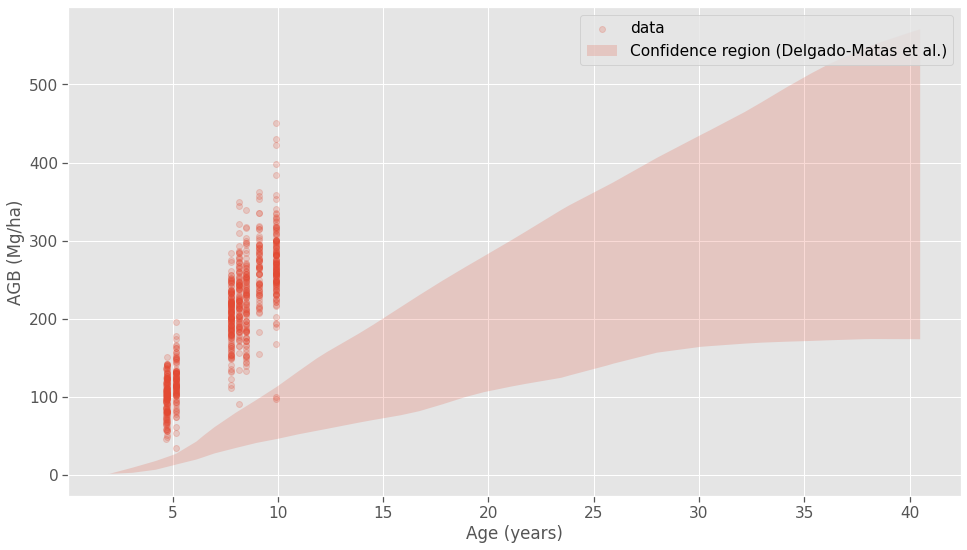

In [156]:
# The unit in Delgado-Matas et al. is m^3/ha, at 1600 trees/ha.
conversion_factor = (
    ureg("m**3/hectare")
    * density
    * trees_per_hectare.magnitude / 1600 # Compensating for the different tree density
).to("Mg/ha").magnitude

growth_delgado = (
    pd.read_csv(data_path/"eucalyptus_growth.csv")
    .rename(columns={
        "x": "age",
        "Volume-max": "upper_bound",
        "Volume-min": "lower_bound",
    })
    .set_index("age")
    * conversion_factor
)

fig, ax = plt.subplots(figsize=(16, 9))
plt.scatter(df["age"], df["volume"], alpha=0.2, label="data", c="C0")

#growth_delgado["Linear fit"].plot(ls="--")
#growth[["Lower bound", "Upper bound"]].plot(ax=ax)
plt.fill_between(growth_delgado.index, growth_delgado["lower_bound"], growth_delgado["upper_bound"], alpha=0.2, label="Confidence region (Delgado-Matas et al.)")

#plt.axhline(50, ls="--", c="gray", label="Approximate saturation point (C-band)")
#plt.axhline(150, ls=":", c="gray", label="Approximate saturation point (L-band)")

plt.legend()
plt.xlabel("Age (years)")
plt.ylabel("AGB (Mg/ha)")

plt.savefig(output_path/"saturation_age_delgado.png")


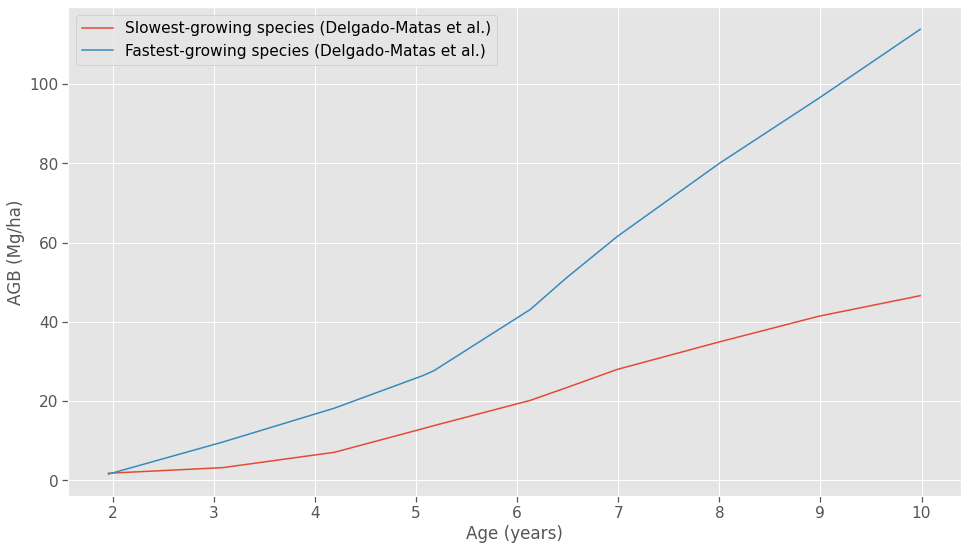

In [159]:
fig, ax = plt.subplots(figsize=(16, 9))
growth_delgado = growth_delgado[:10]
plt.plot(growth_delgado.index, growth_delgado["lower_bound"], label="Slowest-growing species (Delgado-Matas et al.)")
plt.plot(growth_delgado.index, growth_delgado["upper_bound"], label="Fastest-growing species (Delgado-Matas et al.)")

plt.legend()
plt.xlabel("Age (years)")
plt.ylabel("AGB (Mg/ha)")

plt.savefig(output_path/"growth_curves.png")

These results show that there is a problem with the upper and lower bounds we extracted. It could be due to differences between Angola and Uruguay, or to the difference in species, or to problems in conversion. Whatever the cause, we cannot use these bounds for our data.

In [91]:
from scipy.interpolate import interp1d
lower_bound = interp1d(growth.index, growth["lower_bound"])
upper_bound = interp1d(growth.index, growth["upper_bound"])

In [93]:
x = np.linspace(growth.index[0], growth.index[-1], 10000)
lower_array = lower_bound(x)
upper_array = upper_bound(x)

In [96]:
saturation_age_bounds = (x[((upper_array - 50)**2).argmin()], x[((lower_array - 50)**2).argmin()])
saturation_age_bounds

(5.611842724272427, 7.966927222722273)

# Age of saturation (Morris et al.)

In [ ]:
# This time we use a very approximate method because all we have is the MAI.

In [124]:
lr = LinearRegression(fit_intercept=False).fit(df[["age"]], df["volume"])
print("Empirical MAI:", lr.coef_[0])

Empirical MAI: 26.684657698091673


In [164]:
X.shape

(2, 824)

In [169]:
df["age_squared"] = df["age"] ** 2
poly_lr = LinearRegression(fit_intercept=False).fit(df[["age", "age_squared"]], df["volume"])
poly_lr.coef_

array([17.29962191,  1.12296526])

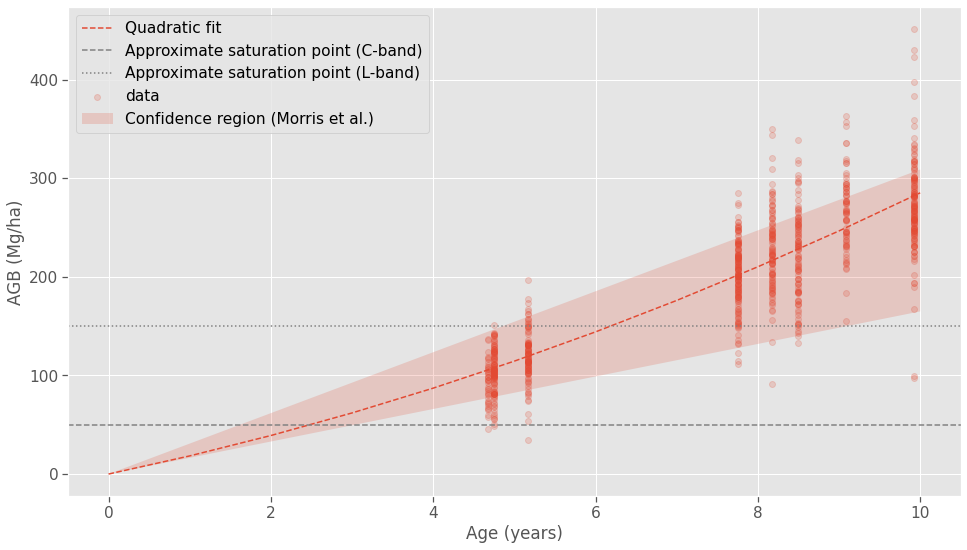

In [171]:
lower_mai = 16.5
upper_mai = 30.9
x = np.arange(11)
growth = pd.DataFrame({
    "Lower bound": lower_mai*x,
    "Upper bound": upper_mai*x,
    "Linear fit": lr.predict(x[:, np.newaxis]),
    "Quadratic fit": poly_lr.predict(np.stack([x, x**2]).T),
}, index=x)

fig, ax = plt.subplots(figsize=(16, 9))
plt.scatter(df["age"], df["volume"], alpha=0.2, label="data", c="C0")

#growth["Linear fit"].plot(ls="--")
growth["Quadratic fit"].plot(ls="--")
#growth[["Lower bound", "Upper bound"]].plot(ax=ax)
plt.fill_between(x, growth["Lower bound"], growth["Upper bound"], alpha=0.2, label="Confidence region (Morris et al.)")

plt.axhline(50, ls="--", c="gray", label="Approximate saturation point (C-band)")
plt.axhline(150, ls=":", c="gray", label="Approximate saturation point (L-band)")

plt.legend()
plt.xlabel("Age (years)")
plt.ylabel("AGB (Mg/ha)")

plt.savefig(output_path/"saturation_age.png")

In [115]:
saturation_age_bounds = (50/upper_mai, 50/lower_mai)
saturation_age_bounds

(1.6181229773462784, 3.0303030303030303)

In [116]:
(150/upper_mai, 150/lower_mai)

(4.8543689320388355, 9.090909090909092)

In [174]:
def solve_quadratic(a, b, c):
    """Find the largest solution to ax^2+bx+c=0.
    Return nan if no such solution exists.
    """
    determinant = b**2 - 4*a*c
    if determinant < 0:
        return np.nan
    
    return (-b + np.sqrt(determinant)) / (2*a)

In [177]:
saturation_df = pd.DataFrame(
    [
        {
            "Band": band,
            "Lower Bound": threshold/upper_mai,
            "Upper Bound": threshold/lower_mai,
            #"Linear fit": threshold/lr.coef_[0],
            "Quadratic fit": solve_quadratic(poly_lr.coef_[1], poly_lr.coef_[0], -threshold),
        }
        for band, threshold in [("C", 50), ("L", 150)]
    ]
).set_index("Band")
print(saturation_df.round(1).to_markdown())

| Band   |   Lower Bound |   Upper Bound |   Quadratic fit |
|:-------|--------------:|--------------:|----------------:|
| C      |           1.6 |           3   |             2.5 |
| L      |           4.9 |           9.1 |             6.2 |


In [173]:
poly_lr.coef_

array([17.29962191,  1.12296526])